<font font color='red' size="8"> **Facial Expression Recognition** </font>

# Abstract

After we finished Andrew Ng's Deep Learning course, We decided to work on a project in order to pratice what we have learn. We selected the Facial Expression Recognition dataset from [Kaggle](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) to see how good our model predict the expressons on human faces and categorize them in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral) and apply the results into solving business questions. We split the project into three phases: 
1. Replicating the [work](https://github.com/acharyarupesh/Facial-Emotion-Recognition-in-Live-Camera) from previous students to use CNN Sequencial model, VGG19 ConColutional Neural Network and Residual Networks 
2. Expanding the results to answer different business questions 
3. Representing our results to the public

# The Dataset

The dataset, named fer2013, consists of 48 * 48 pixel grayscale images of faces. The faces are more or less centered so that it occupises about the same amount of space in each image. We will categorize the facial expression in to one of the seven categories. The "emotion" column contains numeric code from 0-6, inclusive, for the emoton that is present in the images. The "pixels" column has a string, which is space_related pixel values in row major order, surrounded in quotes for each images. From a respective point of view, we will be predicting the "emotion" column .

The training set has 28,709 inputs while the pulic test set has 3,589. The final test set also consists of 3,859 exmaples

Pierre-Luc Carrier and Aaron Courville prepared this dataset as a part of the ongoing project and they allowed access to the Kaggle competition

### CNN
In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery.
CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually refer to fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "fully-connectedness" of these networks make them prone to overfitting data. Typical ways of regularization includes adding some form of magnitude measurement of weights to the loss function. However, CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns. Therefore, on the scale of connectedness and complexity, CNNs are on the lower extreme.

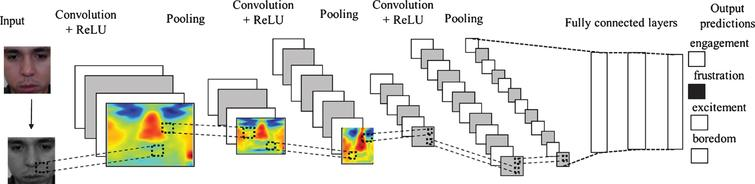

In [30]:
#Grant access to your Google file first 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
# Import necessary packages

import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import keras
from keras.models import Sequential
from tensorflow.keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, MaxPooling2D, Flatten, Activation, Dropout

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import backend as K



sess = tf.compat.v1.Session()
K.set_session(sess)


import numpy as np
import matplotlib.pyplot as plt

#cpu - gpu configuration
config = tf.ConfigProto( device_count = {'GPU': 1, 'CPU': 56} ) #Providing GPU
tf.reset_default_graph() #This will reset the current loaded graph to avoid issues
sess = tf.Session(config=config) 
K.set_session(sess)
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 100

In [32]:
# Importing the dataset 
with open("/content/drive/MyDrive/fer2013.csv") as f:
    content = f.readlines()

In [33]:
#Converting lines to array as the lines represent the pixels
lines = np.array(content)

num_of_instances = lines.size

In [35]:
# Creating training and testing data [4]
x_train, y_train, x_test, y_test = [], [], [], []
for i in range(1,num_of_instances):
    emotion, img, usage = lines[i].split(",")
    val = img.split(" ")
            
    pixels = np.array(val, 'float32')
        
    emotion = keras.utils.to_categorical(emotion, 7)
    #Creating training and testing set
    if 'Training' in usage:                              #IF the "usage" column indicates "Training" then we add to the train set
        y_train.append(emotion)
        x_train.append(pixels)
    elif 'PublicTest' in usage:                          #IF the "usage" column indicates "PublicTest" then we add to the test set
        y_test.append(emotion)
        x_test.append(pixels)

In [36]:
# Converting our training variables to NP array 
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

# Normalizing inputs between [0, 1]
x_train /= 255 
x_test /= 255

# Reshaping the array to 48*48 because the images are 48*48. And 1 is for gray scale and -1 will automatically detect the number of images 
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

28709 train samples
3589 test samples


In [38]:
# Constructing CNN structure
model = Sequential()

                                                            #1st Convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

                                                            #2nd Convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

                                                            #3rd Convolution layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

                                                            #Fully Connected Layers

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

In [40]:
# Batch process, generating batches of tensor image data with real-time data augmentation
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

model.compile(loss='categorical_crossentropy'
    , optimizer='adam'
    , metrics=['accuracy']
)                                                          
                                                           #loss fucntion: categorical_crossentropy  
                                                           #optimizer: adam (the most common one)
                                                           #metric: accuracy

            
# Train for randomly selected one
model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/100
256/256 [==============================] - 30s 83ms/step - batch: 127.5000 - size: 254.2891 - loss: 1.6706 - acc: 0.3716
Epoch 2/100
256/256 [==============================] - 21s 83ms/step - batch: 127.5000 - size: 254.2891 - loss: 1.2096 - acc: 0.5443
Epoch 3/100
256/256 [==============================] - 22s 84ms/step - batch: 127.5000 - size: 253.4336 - loss: 0.9644 - acc: 0.6409
Epoch 4/100
256/256 [==============================] - 21s 83ms/step - batch: 127.5000 - size: 254.2891 - loss: 0.6704 - acc: 0.7540
Epoch 5/100
256/256 [==============================] - 21s 83ms/step - batch: 127.5000 - size: 254.2891 - loss: 0.3611 - acc: 0.8703
Epoch 6/100
256/256 [==============================] - 21s 84ms/step - batch: 127.5000 - size: 254.2891 - loss: 0.2010 - acc: 0.9293
Epoch 7/100
256/256 [==============================] - 21s 83ms/step - batch: 127.5000 - size: 253.4336 - loss: 0.1255 - acc: 0.9577
Epoch 8/100
256/256 [==============================] - 21s 83ms/step 

In [42]:
  # Overall evaluation
score = model.evaluate(x_train, y_train)
print('Train loss:', score[0])
print('Train accuracy:', 100*score[1])

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Train loss: 0.014656286822249126
Train accuracy: 99.45661425590515
Test loss: 4.476158441425067
Test accuracy: 57.62050747871399


In [43]:
# Saving the trained result 
model.save('/content/drive/MyDrive/CNN_saved_final.h5')

In case you cant train train the model above due to unavailable GPU, we can always use this the already trained one that I created right here 

In [41]:
#loading the previously trained model to retrain it (Transfer Learning)
#model.load('/content/drive/MyDrive/CNN_saved_final.h5')

In [44]:
# Create a function to show the emotion of the picture
def detect_emotion(emotions):
    """
    This function classifies the image by converting it NP into array and then predicting the results
    """
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


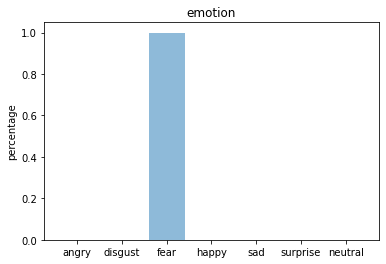

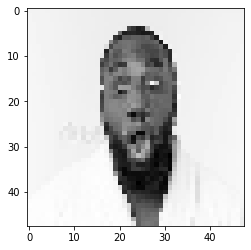

In [49]:
# Applying the function to the picture


img = image.load_img("/content/drive/MyDrive/fear face.jpg", grayscale=True, target_size=(48, 48))      
                                                                                   #Testing the sample from internet

x = image.img_to_array(img)                                                        #Converting image to array
x = np.expand_dims(x, axis = 0)                                                    #This will expand the shape of an array as we already converted the input image to 48x48

x /= 255

emotion_prediction = model.predict(x)
detect_emotion(emotion_prediction[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

### Camera Capture
Using a webcam to capture images for processing on the runtime.

In [50]:
# I have no idea who is the author of the code in this cell that saves an image from a webcam  inside google colab.
# It comes from a notebook called "📸 Take a photo with your webcam"

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return len(binary)

In [51]:
Real_pic = take_photo() # click


**Citations**

For Camera capture- https://gist.github.com/ricardodeazambuja/b79724bd0d091fed4c0d44143e9c3127

For VGG19 and ResNet - https://github.com/tflearn/tflearn/tree/master/examples/images

For tflearn - http://tflearn.org/tutorials/

Article on Facial Emotion Recognition using CNN - http://sefiks.com/2018/01/01/facial-expression-recognition-with-keras/

VGG19 CNN - https://www.mathworks.com/help/deeplearning/ref/vgg19.html;jsessionid=ccf9599bd865b423281a56299a68

